# Example block-wise adaptation using FOTDA and BOTDA

In [2]:
import numpy as np # always need it
from numpy import unravel_index
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import ot
import scipy.io
import mne          
from mne.decoding import CSP
mne.set_log_level(verbose='warning') #to avoid info at terminal
import matplotlib.pyplot as pl
from random import seed
seed(30)
from MIOTDAfunctions import*

In [3]:
results_acc=[]
results_all=[]
results_all_inv=[]

rango_cl=[0.1, 1, 10]
rango_e=[0.1, 1, 10] 
metrica = 'sqeuclidean'
kfold=20

## Load and filter data 

In [4]:
fName = 'Data/DataSession1_S9.mat'
s = scipy.io.loadmat(fName)

Data_S1=s["X"]
Labels_S1=s["y"]
Labels_S1=np.squeeze(Labels_S1)

#filterting with mne
[nt, nc, ns]=np.shape(Data_S1)
Data_S1=np.reshape(Data_S1, [nt, nc*ns])
Data_S1=mne.filter.filter_data(Data_S1, 128, 8, 30)
Data_S1=np.reshape(Data_S1, [nt,nc,ns])

fName = 'Data/DataSession2_S9.mat'
s2 = scipy.io.loadmat(fName)

Data_S2=s2["X"]
Labels_S2=s2["y"]
Labels_S2=np.squeeze(Labels_S2)

#filterting with mne
[nt, nc, ns]=np.shape(Data_S2)
Data_S2=np.reshape(Data_S2, [nt, nc*ns])
Data_S2=mne.filter.filter_data(Data_S2, 128, 8, 30)
Data_S2=np.reshape(Data_S2, [nt,nc,ns])

### Learn CSP+LDA from source data (Data_S1)

In [5]:
Xtr = Data_S1
Ytr = Labels_S1
csp = CSP(n_components=6, reg='empirical', log=True, norm_trace=False, cov_est='epoch')
#learn csp filters
Gtr = csp.fit_transform(Xtr, Ytr)
#learn lda
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
lda.fit(Gtr,Ytr)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
                           solver='lsqr', store_covariance=False, tol=0.0001)

## for each run of 20 trials each learn and apply the transport

In [6]:
for re in range(0,7):
    print('Running testing RUN={:1.0f}'.format(re))
    #testing run
    Xte = Data_S2[0+20*(re+1):20*(re+1)+20]
    Yte = Labels_S2[0+20*(re+1):20*(re+1)+20]
    #transportation set-prior data
    Xval = Data_S2[0:20*re+20]
    Yval = Labels_S2[0:20*re+20]
    
    #feature computation
    Gval = csp.transform(Xval)
    Gte = csp.transform(Xte)
    
    #evaluate SC  
    acc_sc = lda.score(Gte, Yte)

    #evaluate SR
    Xtr2add = Data_S2[0:20*re+20]
    Ytr2add=Labels_S2[0:20*re+20]
    Xtr2 = np.vstack(((Xtr, Xtr2add)))
    Ytr2 = np.hstack(((Ytr, Ytr2add)))
        
    Ytr2 = Ytr2[len(Ytr2add):]
    Xtr2 = Xtr2[len(Ytr2add):]

    csp2 = CSP(n_components=6, reg='empirical', log=True, norm_trace=False, cov_est='epoch')
    #learn new csp filters
    Gtr2 = csp2.fit_transform(Xtr2,Ytr2)
    #learn new lda
    lda2 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
    lda2.fit(Gtr2,Ytr2)

    Gte2 = csp2.transform(Xte)
    Gval2 = csp2.transform(Xval)
    #ldatest
    acc_sr = lda2.score(Gte2, Yte)


    M=40
    
    
    #%% # Sinkhorn Transport
    # Subset selection
    lda3 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

    G_FOTDAs_, Y_FOTDAs_, regu_FOTDAs_=SelectSubsetTraining_OTDAs(Gtr, Ytr, Gval, Yval, rango_e, lda3, metrica, kfold, M)


    Gtr_daot=G_FOTDAs_
    Ytr_daot=Y_FOTDAs_ 
    ot_sinkhorn= ot.da.SinkhornTransport(metric=metrica, reg_e=regu_FOTDAs_)
    #learn the map
    ot_sinkhorn.fit(Xs=Gtr_daot, ys=Ytr_daot, Xt=Gval)
    #apply the mapping over source data
    transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=Gtr)

    # train a new classifier bases upon the transform source data
    lda3.fit(transp_Xs_sinkhorn,Ytr)
    # Compute acc
    yt_predict_1=lda3.predict(Gte)
    acc_fotdas=accuracy_score(Yte, yt_predict_1)
    
    #%% # Group-Lasso Transport
    # Subset selection


    lda3 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

    G_FOTDAl1l2_, Y_FOTDAl1l2_, regu_FOTDAl1l2_=\
    SelectSubsetTraining_OTDAl1l2(Gtr, Ytr, Gval, Yval, rango_e, rango_cl, lda3, metrica, kfold, M)

    Gtr_daot=G_FOTDAl1l2_
    Ytr_daot=Y_FOTDAl1l2_
    
    ot_l1l2 = ot.da.SinkhornL1l2Transport(metric=metrica ,reg_e=regu_FOTDAl1l2_[0], reg_cl=regu_FOTDAl1l2_[1])

    ot_l1l2.fit(Xs=Gtr_daot, ys=Ytr_daot, Xt=Gval)

    #transport taget samples onto source samples
    transp_Xs_l1l2=ot_l1l2.transform(Xs=Gtr)

    # train a new classifier bases upon the transform source data
    lda3.fit(transp_Xs_l1l2,Ytr)

    # Compute acc
    yt_predict_2=lda3.predict(Gte)
    acc_fotdal1l2=accuracy_score(Yte, yt_predict_2)
    
        
    #%% # Backward Sinkhorn Transport
    # Subset selection

    G_BOTDAs_, Y_BOTDAs_, regu_BOTDAs_=\
    subset_xs_bs, subset_ys_bs, reg_best_bs= SelectSubsetTraining_BOTDAs(Gtr, Ytr, Gval, Yval, rango_e, lda, metrica, kfold, M)

    Gtr_botda=G_BOTDAs_
    Ytr_botda=Y_BOTDAs_
    
    bot_s = ot.da.SinkhornTransport(metric=metrica, reg_e=regu_BOTDAs_)
    
    
    bot_s.fit(Xs=Gval, ys=Yval, Xt=Gtr_botda, yt=Ytr_botda)
    #transport testing samples
    transp_Xt_s_backward=bot_s.transform(Xs=Gte)
    # Compute accuracy without retraining    
    yt_predict_3=lda.predict(transp_Xt_s_backward)
    acc_botdas=accuracy_score(Yte, yt_predict_3)
    
    #%% # Backward Group-Lasso Transport
    # Subset selection 
    G_BOTDAl1l2_, Y_BOTDAl1l2_, regu_BOTDAl1l2_=\
    SelectSubsetTraining_BOTDAl1l2(Gtr, Ytr, Gval, Yval, rango_e, rango_cl, lda, metrica, kfold, M)

    Gtr_botda=G_BOTDAl1l2_
    Ytr_botda=Y_BOTDAl1l2_
    
    bot_l1l2 = ot.da.SinkhornL1l2Transport(metric=metrica, reg_e=regu_BOTDAl1l2_[0], reg_cl=regu_BOTDAl1l2_[1])
    
    
    bot_l1l2.fit(Xs=Gval, ys=Yval, Xt=Gtr_botda, yt=Ytr_botda)
    #transport testing samples
    transp_Xt_l1l2_backward=bot_l1l2.transform(Xs=Gte)
    # Compute accuracy without retraining    
    yt_predict_4=lda.predict(transp_Xt_l1l2_backward)
    acc_botdal1l2=accuracy_score(Yte, yt_predict_4)
    # print results
    acc={}
    acc["sc"]=acc_sc
    acc["sr"]=acc_sr
    acc["fotda_s"]=acc_fotdas
    acc["fotda_l1l2"]=acc_fotdal1l2
    acc["botda_s"]=acc_botdas
    acc["botda_l1l2"]=acc_botdal1l2
    
    print(acc)  
    

Running testing RUN=0
{'sc': 0.55, 'sr': 0.6, 'fotda_s': 0.75, 'fotda_l1l2': 0.65, 'botda_s': 0.8, 'botda_l1l2': 0.7}
Running testing RUN=1
{'sc': 0.75, 'sr': 0.8, 'fotda_s': 0.85, 'fotda_l1l2': 0.85, 'botda_s': 0.65, 'botda_l1l2': 0.7}
Running testing RUN=2
{'sc': 0.65, 'sr': 0.75, 'fotda_s': 0.8, 'fotda_l1l2': 0.75, 'botda_s': 0.9, 'botda_l1l2': 0.9}
Running testing RUN=3
{'sc': 0.7, 'sr': 0.8, 'fotda_s': 0.8, 'fotda_l1l2': 0.75, 'botda_s': 0.8, 'botda_l1l2': 0.85}
Running testing RUN=4
{'sc': 0.9, 'sr': 0.85, 'fotda_s': 0.95, 'fotda_l1l2': 0.95, 'botda_s': 1.0, 'botda_l1l2': 0.9}
Running testing RUN=5
{'sc': 0.7, 'sr': 0.75, 'fotda_s': 0.6, 'fotda_l1l2': 0.7, 'botda_s': 0.65, 'botda_l1l2': 0.65}
Running testing RUN=6
{'sc': 0.7, 'sr': 0.65, 'fotda_s': 0.6, 'fotda_l1l2': 0.7, 'botda_s': 0.6, 'botda_l1l2': 0.65}


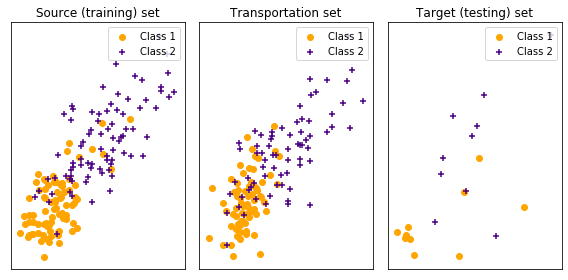

In [7]:
#Plotting-->for the last testing run

#min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
#Gtr_norm = min_max_scaler.fit_transform(Gtr)    
#Gte_norm = min_max_scaler.fit_transform(Gte) 
#Gval_norm = min_max_scaler.fit_transform(Gval)    

Gtr_norm,Gte_norm, Gval_norm = Gtr, Gte, Gval
#distribution datasets
pl.figure(figsize=(8, 4))

pl.subplot(1, 3, 1)
pl.scatter(Gtr_norm[Ytr==1, 0], Gtr_norm[Ytr==1, 1], c='orange', marker='o', label='Class 1')
pl.scatter(Gtr_norm[Ytr==2, 0], Gtr_norm[Ytr==2, 1], c='indigo', marker='+', label='Class 2')

pl.xticks([])
pl.yticks([])
pl.legend(loc=1)
pl.title('Source (training) set')

pl.subplot(1, 3, 2)
pl.scatter(Gval_norm[Yval==1, 0], Gval_norm[Yval==1, 1], c='orange', marker='o', label='Class 1')
pl.scatter(Gval_norm[Yval==2, 0], Gval_norm[Yval==2, 1], c='indigo', marker='+', label='Class 2')

pl.xticks([])
pl.yticks([])
pl.legend(loc=1)
pl.title('Transportation set')
pl.tight_layout()

    
pl.subplot(1, 3, 3)
pl.scatter(Gte_norm[Yte==1, 0], Gte_norm[Yte==1, 1], c='orange', marker='o', label='Class 1')
pl.scatter(Gte_norm[Yte==2, 0], Gte_norm[Yte==2, 1], c='indigo', marker='+', label='Class 2')

pl.xticks([])
pl.yticks([])
pl.legend(loc=1)
pl.title('Target (testing) set' )
pl.tight_layout()



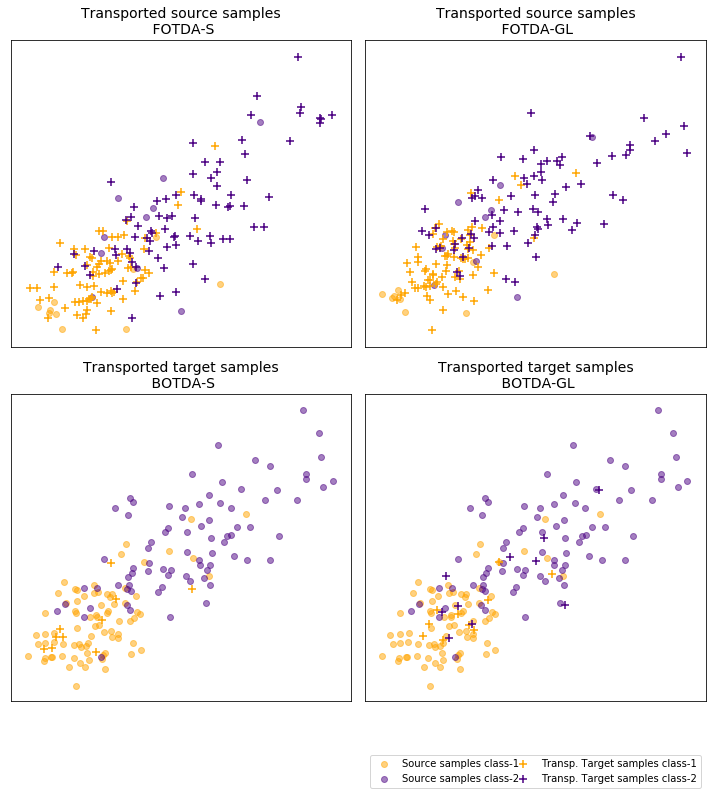

In [8]:
# plotting original and transported samples for each method
#%% scalling
pl.figure(figsize=(10, 11))
    
pl.subplot(2, 2, 1)
pl.scatter(Gte_norm[Yte==1, 0], Gte_norm[Yte==1, 1], c='orange', marker='o',
           alpha=0.5)
pl.scatter(Gte_norm[Yte==2, 0], Gte_norm[Yte==2, 1], c='indigo', marker='o',
           alpha=0.5)
pl.scatter(transp_Xs_sinkhorn[Ytr==1, 0], transp_Xs_sinkhorn[Ytr==1, 1], c='orange',
           marker='+', s=50 )
pl.scatter(transp_Xs_sinkhorn[Ytr==2, 0], transp_Xs_sinkhorn[Ytr==2, 1], c='indigo',
           marker='+', s=50 )
pl.title('Transported source samples\n FOTDA-S', size=14)
pl.xticks([])
pl.yticks([])

#l1l2
pl.subplot(2, 2, 2)
pl.scatter(Gte_norm[Yte==1, 0], Gte_norm[Yte==1, 1], c='orange', marker='o',
           alpha=0.5)
pl.scatter(Gte_norm[Yte==2, 0], Gte_norm[Yte==2, 1], c='indigo', marker='o',
           alpha=0.5)
pl.scatter(transp_Xs_l1l2[Ytr==1, 0], transp_Xs_l1l2[Ytr==1, 1], c='orange',
           marker='+', s=50 )
pl.scatter(transp_Xs_l1l2[Ytr==2, 0], transp_Xs_l1l2[Ytr==2, 1], c='indigo',
           marker='+', s=50 )
pl.title('Transported source samples\n FOTDA-GL', size=14)
pl.xticks([])
pl.yticks([])


#S-B
pl.subplot(2, 2, 3)
pl.scatter(Gtr_norm[Ytr==1, 0], Gtr_norm[Ytr==1, 1], c='orange', marker='o',alpha=0.5)
pl.scatter(Gtr_norm[Ytr==2, 0], Gtr_norm[Ytr==2, 1], c='indigo', marker='o',alpha=0.5)

pl.scatter(transp_Xt_s_backward[Yte==1, 0], transp_Xt_s_backward[Yte==1, 1], c='orange',
            marker='+', s=50)
pl.scatter(transp_Xt_s_backward[Yte==2, 0], transp_Xt_s_backward[Yte==2, 1], c='indigo',
            marker='+', s=0)
pl.title('Transported target samples\n BOTDA-S', size=14)
pl.xticks([])
pl.yticks([])

    
#l1l2-B
pl.subplot(2, 2, 4)
pl.scatter(Gtr_norm[Ytr==1, 0], Gtr_norm[Ytr==1, 1], c='orange', marker='o',alpha=0.5, 
           Label='Source samples class-1')
pl.scatter(Gtr_norm[Ytr==2, 0], Gtr_norm[Ytr==2, 1], c='indigo', marker='o',alpha=0.5,
           Label='Source samples class-2')

pl.scatter(transp_Xt_l1l2_backward[Yte==1, 0], transp_Xt_l1l2_backward[Yte==1, 1], c='orange',
            marker='+', s=50, Label='Transp. Target samples class-1')
pl.scatter(transp_Xt_l1l2_backward[Yte==2, 0], transp_Xt_l1l2_backward[Yte==2, 1], c='indigo',
            marker='+', s=50, Label='Transp. Target samples class-2')
pl.title('Transported target samples\n BOTDA-GL', size=14)
pl.legend(loc=8, ncol=2, mode="expand", bbox_to_anchor=(0, -0.3, 1, 0.65))
pl.xticks([])
pl.yticks([])
pl.tight_layout()